<a href="https://colab.research.google.com/github/suryogumilar/Tensorflow_timeseries/blob/main/C4_W3_Lab_1_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recurrent Neural Network (RNN) for time series forecasting

In [85]:
import tensorflow as tf
import numpy as np
import pandas as pd
import datetime
from dateutil.relativedelta import relativedelta
# for timezone()
import pytz
import math
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.graph_objects as go
from IPython.display import clear_output
import random
import os

## functions

define some utility functions that repeatedly use

#### Plot functions

In [3]:
def plot_series(time, series, format="-", start=0, end=None):
    """
    Visualizes time series data

    Args:
      time (array of int) - contains the time steps
      series (array of int) - contains the measurements for each time step
      format - line style when plotting the graph
      label - tag for the line
      start - first time step to plot
      end - last time step to plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    if type(series) is tuple:

      for series_num in series:
        # Plot the time series data
        plt.plot(time[start:end], series_num[start:end], format)

    else:
      # Plot the time series data
      plt.plot(time[start:end], series[start:end], format)

    # Label the x-axis
    plt.xlabel("Time")

    # Label the y-axis
    plt.ylabel("Value")

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

In [4]:
def plot_series_plotly(time, series, series_name=None, 
                       figure_title='', showlegend=False, 
                       start=0, end=None):
    """
    Visualizes time series data but using plotly for interactive graph

    Args:
      time (array of int) - contains the time steps
      series (array of int) - contains the measurements for each time step
      series_name (array of string) - contains correlative name of each series
      format - line style when plotting the graph
      label - tag for the line
      start - first time step to plot
      end - last time step to plot
    """
    fig = go.Figure()
    # Setup dimensions of the graph figure
    
    if type(series) is tuple:
      ii = 0
      for series_num in series:
        # Plot the time series data
        fig.add_trace(go.Scatter(x=time[start:end],
                                 y=series_num[start:end], mode='lines',
                                 name=series_name[ii]))  
        ii = ii+1
    else:
      # Plot the time series data
      fig.add_trace(go.Scatter(x=time[start:end],
                                 y=series[start:end], mode='lines'))

    fig.update_layout(title=figure_title, xaxis_title="Time", yaxis_title="Value",
                      autosize=False,
                      width=600,
                      height=600,
                      margin=dict(
                        l=50,
                        r=50,
                        b=100,
                        t=100,
                        pad=4
                        ), paper_bgcolor="LightSteelBlue"
                        , showlegend=showlegend
                      )
    fig.show()
     

In [5]:
def plot_candlesticks(df, figure_title='', showlegend=False):
  fig = go.Figure(data= [go.Candlestick(x=df['Date'],
                             open=df['Open'],
                             high=df['High'],
                             low=df['Low'],
                             close=df['Close']
                             )])
  fig.update_layout(title=figure_title, xaxis_title="Time", yaxis_title="Value",
                    autosize=False,
                    width=600,
                    height=600,
                    margin=dict(
                        l=50,
                        r=50,
                        b=100,
                        t=100,
                        pad=4
                    ),
                    paper_bgcolor="LightSteelBlue", showlegend=showlegend
                  )
  fig.show()
     

#### function to gather data

In [6]:
def getStockData(history_span:int, the_ticker:str):
  """
  Getting stock data from Yahoo Finance API

  Args:
    history_span (int) how much backdate data to be collected
    the_ticker (string) ticker name on yahoo finance API
  Returns:
    Pandas dataframe (pd.DataFrame) containing stock data    
  """
  THE_URL = ('https://query1.finance.yahoo.com/v7/finance/'+
           'download/{ticker}?period1={period1}&period2={period2}&interval=1d&events=history&includeAdjustedClose=true')
  tdy = datetime.datetime.now(tz=pytz.timezone('Asia/Jakarta'))

  p2 = math.ceil(tdy.timestamp())
  p1 = math.floor((tdy - relativedelta(years=history_span)).timestamp())
  yf_url = THE_URL.format(ticker=the_ticker,period1=p1, period2=p2)
  df = pd.read_csv(yf_url)
  df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
  return df

#### Make windowed data for time series forecasting


In [7]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """
  
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

##### Tensorflow function

In [8]:
def set_seed(seed: int = 42) -> None:
  random.seed(seed)
  np.random.seed(seed)
  tf.random.set_seed(seed)
  tf.experimental.numpy.random.seed(seed)

  try:
    tf.set_random_seed(seed)
  except AttributeError as ae:
    print('INFO: tf.set_random_seed is deprecated in tf version ', tf.__version__, ' ',ae )
  
  # When running on the CuDNN backend, two further options must be set
  os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
  os.environ['TF_DETERMINISTIC_OPS'] = '1'
  # Set a fixed value for the hash seed
  os.environ["PYTHONHASHSEED"] = str(seed)
  print(f"Random seed set as {seed}")


## get data

In [9]:
stock_name = str(input("Stock tick:"))
hist_data = int(input("historical data (year):"))

Stock tick:TLKM.JK
historical data (year):3


In [87]:
df = getStockData(hist_data, stock_name)

##### plotting the data

In [88]:
plot_series_plotly(df['Date'], (df['Open'], df['Close']),
                   series_name=['Open', 'Close'],
                   figure_title='price', showlegend=True)

In [89]:
plot_candlesticks(df,  figure_title='stocks')

## Split the Dataset

split the dataset as training and test

Please do note in mind that when splitting the data into training and test set always take care on the distribution of data. Does it represent data on each month equally? Does the data have seasonal feature in it? Does it actually creates bias instead?

In [90]:
split_ratio = 0.8
rows_of_dataframe = df.shape[0]

training_ds_rows = round(rows_of_dataframe * split_ratio)
test_ds_rows = round(rows_of_dataframe * (1- split_ratio))

df_training = df[:training_ds_rows]
df_test = df[training_ds_rows:]

print(df.shape)
print(df_training.shape)
print(df_test.shape)

(735, 7)
(588, 7)
(147, 7)


### Normalize

we normalize the training data first. Also we add denormalizer to return predicted data into its real values

In [91]:
## define the normalizer
normalizer_univar = tf.keras.layers.Normalization(axis=None)
denormalizer_univar = tf.keras.layers.Normalization(axis=None, invert=True)

# trin the normalizer to training set
training_set = tf.convert_to_tensor(df_training['Close'])
print(training_set.shape)
normalizer_univar.adapt(training_set)

# we get normalized training set
training_set_normalized = normalizer_univar(training_set)

# train denormalizer layer
denormalizer_univar.adapt(training_set)

# we tray to reverse from normalized into the actual training set values
training_set_denormalized = denormalizer_univar(training_set_normalized)

test_set = tf.convert_to_tensor(df_test['Close'])

test_set_normalized = normalizer_univar(test_set)


(588,)


#### statistical characteristics of training set

In [92]:
print('training set range:')
print('before normalized:')
print('min:',tf.reduce_min(training_set, axis=0).numpy())
print('max:', tf.reduce_max(training_set, axis=0).numpy())
print('mean:', tf.reduce_mean(training_set, axis=0).numpy())

training set range:
before normalized:
min: 2560.0
max: 4770.0
mean: 3536.173469387755


##### statistical characteristics of denormalized training set

In [93]:
print('after denormalized:')
print('min:',tf.reduce_min(training_set_denormalized, axis=0).numpy())
print('max:', tf.reduce_max(training_set_denormalized, axis=0).numpy())
print('mean:', tf.reduce_mean(training_set_denormalized, axis=0).numpy())


after denormalized:
min: 2560.0
max: 4770.0
mean: 3536.1736


### T-test

let us compare the raw training set and denormalized training set. This is to test wether we suceed on creating denormalizer layer

In [94]:
# Import library
import scipy.stats as stats

# Print the variance of both data groups
print(np.var(training_set), np.var(training_set_denormalized))

# Perform the two sample t-test with equal variances
print(stats.ttest_ind(a=training_set, b=training_set_denormalized, equal_var=True))

281602.19439816737 281602.22
Ttest_indResult(statistic=-3.699626133518733e-06, pvalue=0.9999970487539538)


Two sample t-test has the following hypothesis:

> H0 => µ1 = µ2 (population mean of dataset1 is equal to dataset2)
>
> HA => µ1 ≠µ2 (population mean of dataset1 is different from dataset2)

Here, since the p-value (0.99) is greater than alpha = 0.05 so we cannot reject the null hypothesis of the test.

so the population mean of denormalized version of training set is equal to the real training set. Hence, the normalization and denormalization layer work perfectly
 


## Prepare features and labels

prepare window data for time series forecasting

In [95]:
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

# Generate the dataset windows
windowed_training_ds = windowed_dataset(training_set_normalized, window_size, 
                           batch_size, shuffle_buffer_size)

# Print properties of a single batch
for windows in windowed_training_ds.take(1):
  print(f'data type: {type(windows)}')
  print(f'number of elements in the tuple: {len(windows)}')
  print(f'shape of first element: {windows[0].shape}')
  print(f'shape of second element: {windows[1].shape}')
  print(f'shape of first element expanded: {tf.expand_dims(windows[0], axis=-1).shape}')

data type: <class 'tuple'>
number of elements in the tuple: 2
shape of first element: (32, 20)
shape of second element: (32,)
shape of first element expanded: (32, 20, 1)


## Build and compile the model


Your model is composed mainly of [SimpleRNN](https://www.tensorflow.org/api_docs/python/tf/keras/layers/SimpleRNN) layers. As mentioned in the lectures, this type of RNN simply routs its output back to the input. You will stack two of these layers in your model so the first one should have `return_sequences` set to `True`. 

As mentioned in the [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/SimpleRNN#call_arguments), `SimpleRNN` layers expect a 3-dimensional tensor input with the shape `[batch, timesteps, feature`]. With that, you need to reshape your window from `(32, 20)` to `(32, 20, 1)`. This means the 20 datapoints in the window will be mapped to 20 timesteps of the RNN. You can do this reshaping in a separate cell but you can also do this within the model itself by using [Lambda](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Lambda) layers. Notice the first layer below. It defines a lambda function that adds a dimension at the last axis of the input. That's exactly the transformation you need. For the `input_shape`, you can specify `None` (like in the lecture video) if you want the model to be more flexible with the number of timesteps. Alternatively, you can set it to `window_size` as shown below if you want to set the `timesteps` dimension to the expected size of your data windows.

Normally, you can just a have a `Dense` layer output as shown in the previous labs. However, you can help the training by scaling up the output to around the same figures as your labels. This will depend on the [activation functions](https://en.wikipedia.org/wiki/Activation_function#Table_of_activation_functions) you used in your model. `SimpleRNN` uses *tanh* by default and that has an output range of `[-1,1]`. You will use another `Lambda()` layer to scale the output by 100 before it adjusts the layer weights. Feel free to remove this layer later after this lab and see what results you get.

In [229]:
class TS_RNN_Model(tf.keras.Model):
  def __init__(self, window_size,
               normalizer_layer=None,
               denormalizer_layer=None,
               **kwargs):
    super(TS_RNN_Model, self).__init__(**kwargs)

    self.normalizer_1 = normalizer_layer
    self.denormalizer_1 = denormalizer_layer
    model_tune = tf.keras.models.Sequential([
      tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                         input_shape=[window_size]),
      tf.keras.layers.SimpleRNN(40, return_sequences=True),
      tf.keras.layers.SimpleRNN(40),
      tf.keras.layers.Dense(1),
      tf.keras.layers.Lambda(lambda x: x * 100.0)
    ])
    self.seq_1 = model_tune

  def normalize(self, x):
    return self.normalizer_1(x)
  
  def denormalize(self, x):
    return self.denormalizer_1(x)

  @tf.function   
  def call(self, x):
    x = self.seq_1(x)
    return x

In [230]:
# setting random seeds
set_seed(1)
model_tune1 = TS_RNN_Model(window_size=window_size, 
                              normalizer_layer=normalizer_univar,
                              denormalizer_layer=denormalizer_univar)
#model_baseline.build(input_shape = (1, window_size))
# Print the model summary
#model_baseline.summary()

INFO: tf.set_random_seed is deprecated in tf version  2.11.0   module 'tensorflow' has no attribute 'set_random_seed'
Random seed set as 1


## Tune the Learning Rate


You will then tune the learning rate as before. You will define a learning rate schedule that changes this hyperparameter dynamically. You will use the [Huber Loss](https://en.wikipedia.org/wiki/Huber_loss) as your loss function to minimize sensitivity to outliers.

In [231]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer1 = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model_tune1.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer1)

# Train the model
history_tune1 = model_tune1.fit(windowed_training_ds, epochs=100, callbacks=[lr_schedule],
                         verbose=0)

visualize the results and pick an optimal learning rate.

(1e-08, 0.001, 0.0, 50.0)

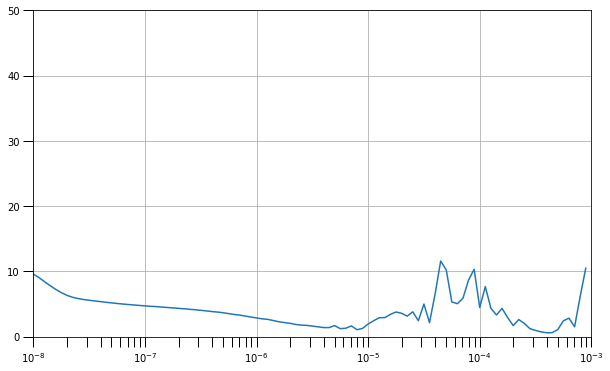

In [232]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history_tune1.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 50])

change the boundaries of the graph if you want to zoom in. The cell below chooses a narrower range so you can see more clearly where the graph becomes unstable.

(1e-06, 0.001, 0.0, 20.0)

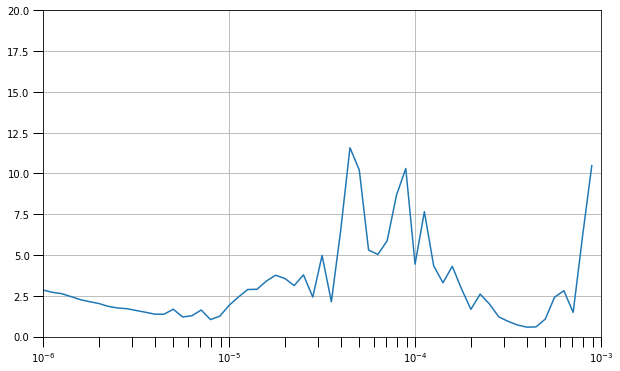

In [233]:
# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history_tune1.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-6, 1e-3, 0, 20])

(0.0002, 0.0003, 0.0, 20.0)

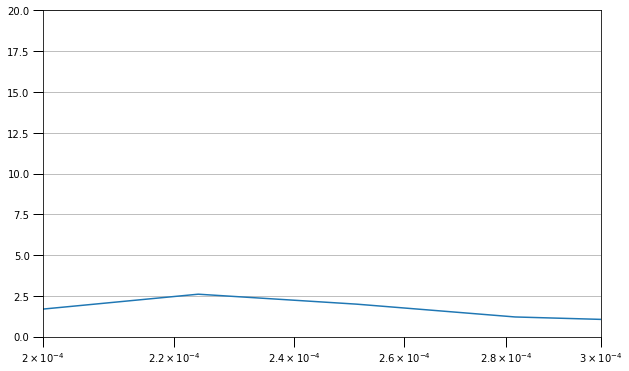

In [234]:
# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history_tune1.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([2e-4, 3e-4, 0, 20])

this time we declare the input shape

In [235]:
# setting random seeds
set_seed(1)
model_tune2 = TS_RNN_Model(window_size=window_size, 
                              normalizer_layer=normalizer_univar,
                              denormalizer_layer=denormalizer_univar)
model_tune2.build(input_shape = (batch_size, window_size))
# Print the model summary
model_tune2.summary()

INFO: tf.set_random_seed is deprecated in tf version  2.11.0   module 'tensorflow' has no attribute 'set_random_seed'
Random seed set as 1
Model: "ts_rnn__model_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_2 (Normalizat  multiple                 3         
 ion)                                                            
                                                                 
 normalization_3 (Normalizat  multiple                 3         
 ion)                                                            
                                                                 
 sequential_47 (Sequential)  (None, 1)                 4961      
                                                                 
Total params: 4,967
Trainable params: 4,961
Non-trainable params: 6
_________________________________________________________________


In [236]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer2 = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model_tune2.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer2)

# Train the model
history2 = model_tune2.fit(windowed_training_ds, epochs=100, callbacks=[lr_schedule],
                         verbose=0)

(1e-08, 0.001, 0.0, 50.0)

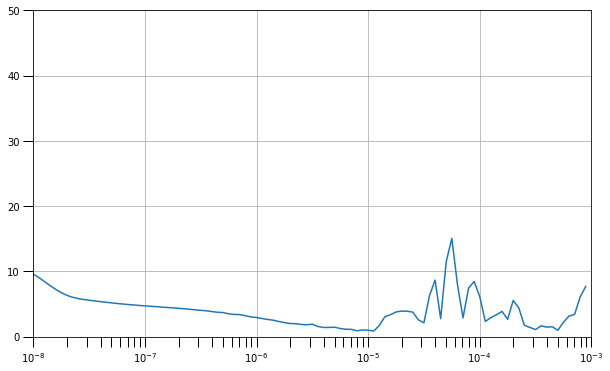

In [237]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history2.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 50])

(1e-06, 0.001, 0.0, 20.0)

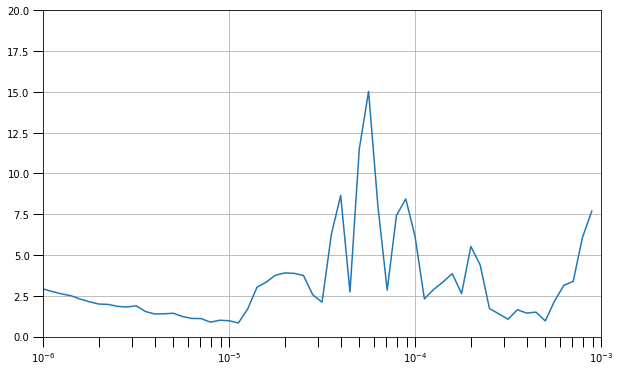

In [238]:
# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history2.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-6, 1e-3, 0, 20])

(0.0001, 0.001, 0.0, 20.0)

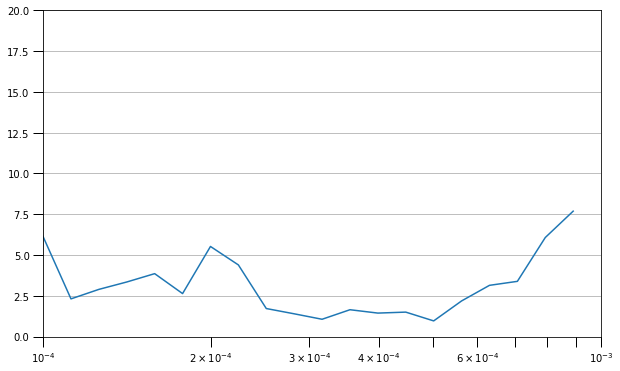

In [239]:
# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history2.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-4, 1e-3, 0, 20])

(0.0003, 0.0004, 0.0, 20.0)

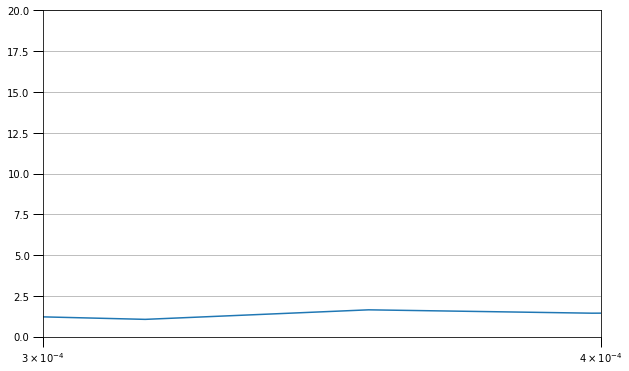

In [240]:
# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history2.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([3e-4, 4e-4, 0, 20])

In [241]:
# setting random seeds
set_seed(1)
model_tune3 = TS_RNN_Model(window_size=window_size, 
                              normalizer_layer=normalizer_univar,
                              denormalizer_layer=denormalizer_univar)
model_tune3.build(input_shape = (1, window_size))
# Print the model summary
#model_baseline.summary()

INFO: tf.set_random_seed is deprecated in tf version  2.11.0   module 'tensorflow' has no attribute 'set_random_seed'
Random seed set as 1


In [242]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer2 = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model_tune3.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer2)

# Train the model
history3 = model_tune3.fit(windowed_training_ds, epochs=100, callbacks=[lr_schedule],
                         verbose=0)

(1e-08, 0.001, 0.0, 50.0)

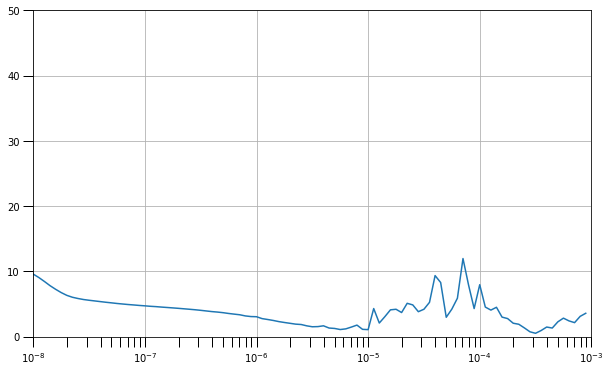

In [243]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history3.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 50])

(0.0002, 0.0004, 0.0, 50.0)

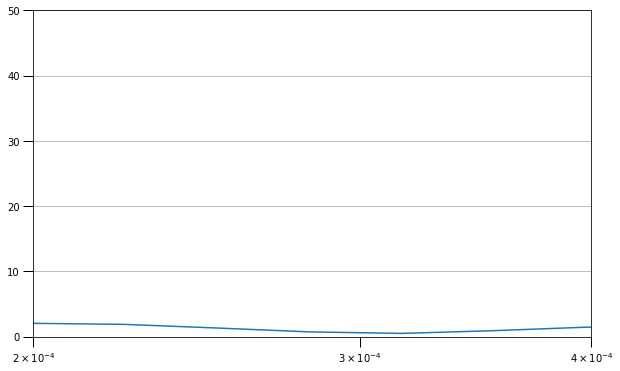

In [244]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history3.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([2e-4, 4e-4, 0, 50])

based on those graphs of loss value, we choose 
no built = `2.8e-4`

input shape is batchsize x window size = `3.5 * (10 **-4)`

input shape is 1 x window size = `3.5 * (10 **-4)`


## Train the Model

You can then declare the model again and train with the learning rate you picked. It is set to 1e-6by default but feel free to change it.

In [245]:
# setting random seeds
set_seed(1)
model_wbuilt1 = TS_RNN_Model(window_size=window_size, 
                              normalizer_layer=normalizer_univar,
                              denormalizer_layer=denormalizer_univar)
model_wbuilt1.build(input_shape = (1, window_size))
# Print the model summary
model_wbuilt1.summary()

INFO: tf.set_random_seed is deprecated in tf version  2.11.0   module 'tensorflow' has no attribute 'set_random_seed'
Random seed set as 1
Model: "ts_rnn__model_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_2 (Normalizat  multiple                 3         
 ion)                                                            
                                                                 
 normalization_3 (Normalizat  multiple                 3         
 ion)                                                            
                                                                 
 sequential_49 (Sequential)  (None, 1)                 4961      
                                                                 
Total params: 4,967
Trainable params: 4,961
Non-trainable params: 6
_________________________________________________________________


In [246]:
# setting random seeds
set_seed(1)
model_wbuilt_bs = TS_RNN_Model(window_size=window_size, 
                              normalizer_layer=normalizer_univar,
                              denormalizer_layer=denormalizer_univar)
model_wbuilt_bs.build(input_shape = (batch_size, window_size))
# Print the model summary
model_wbuilt_bs.summary()

INFO: tf.set_random_seed is deprecated in tf version  2.11.0   module 'tensorflow' has no attribute 'set_random_seed'
Random seed set as 1
Model: "ts_rnn__model_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_2 (Normalizat  multiple                 3         
 ion)                                                            
                                                                 
 normalization_3 (Normalizat  multiple                 3         
 ion)                                                            
                                                                 
 sequential_50 (Sequential)  (None, 1)                 4961      
                                                                 
Total params: 4,967
Trainable params: 4,961
Non-trainable params: 6
_________________________________________________________________


In [247]:
# setting random seeds
set_seed(1)
model_nobuilt = TS_RNN_Model(window_size=window_size, 
                              normalizer_layer=normalizer_univar,
                              denormalizer_layer=denormalizer_univar)

INFO: tf.set_random_seed is deprecated in tf version  2.11.0   module 'tensorflow' has no attribute 'set_random_seed'
Random seed set as 1


compile

In [248]:
# Set the learning rate
learning_rate = 3.6e-4
learning_rate = 2.8e-4

# Set the optimizer 
optimizer_wbuilt1 = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model_wbuilt1.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer_wbuilt1,
              metrics=["mae"])

In [249]:
# Set the learning rate
learning_rate = 3.5e-4
learning_rate = 2.8e-4

# Set the optimizer 
optimizer_wbuilt_bs = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model_wbuilt_bs.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer_wbuilt_bs,
              metrics=["mae"])

In [250]:
# Set the learning rate
learning_rate = 2.8e-4
#learning_rate = 3.6e-4

# Set the optimizer 
optimizer_nobuilt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model_nobuilt.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer_nobuilt,
              metrics=["mae"])

In [251]:
# Generate the dataset windows
windowed_training_ds_wb1 = windowed_dataset(training_set_normalized, window_size, 
                           batch_size, shuffle_buffer_size)
windowed_training_ds_wbbs = windowed_dataset(training_set_normalized, window_size, 
                           batch_size, shuffle_buffer_size)
windowed_training_ds_nb = windowed_dataset(training_set_normalized, window_size, 
                           batch_size, shuffle_buffer_size)

In [252]:
history_wbuilt1 = model_wbuilt1.fit(windowed_training_ds_wb1, epochs=100, verbose=0)
history_wbuilt_bs = model_wbuilt_bs.fit(windowed_training_ds_wbbs, epochs=100, verbose=0)
history_nobuilt =  model_nobuilt.fit(windowed_training_ds_nb, epochs=100, verbose=0)


In [253]:

print('with built input_shape = (1, window_size):',
      history_wbuilt1.history['loss'][-1])
print('with built input_shape = (batch_size, window_size):',
      history_wbuilt_bs.history['loss'][-1])

print('with no built:',
      history_nobuilt.history['loss'][-1])


with built input_shape = (1, window_size): 0.024853447452187538
with built input_shape = (batch_size, window_size): 0.015526930801570415
with no built: 0.11269474029541016


## Model Prediction

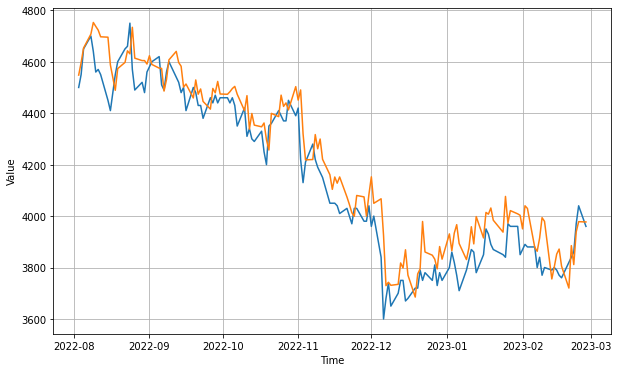

In [254]:
# Initialize a list
forecast = []

dataset_to_forecast = df['Close'].iloc[training_ds_rows-window_size:]
dateset_to_forecast_normalized = normalizer_univar(dataset_to_forecast)
for time in range(dateset_to_forecast_normalized.shape[0] - window_size):
  the_prediction = model_wbuilt_bs.predict(
      np.expand_dims(dateset_to_forecast_normalized[time:time + window_size], 
                     axis=0), 
      verbose=0)
  the_prediction_denorm = denormalizer_univar(the_prediction)
  forecast.append(the_prediction_denorm)
  
# Convert to a numpy array and drop single dimensional axes
results = np.array(forecast).squeeze()

# Overlay the results with the validation set
plot_series(df_test['Date'], (test_set, results) )


In [255]:
# Compute the metrics
print(tf.keras.metrics.mean_squared_error(test_set, results).numpy())
print(tf.keras.metrics.mean_absolute_error(test_set, results).numpy())

10435.914
80.678734


## tomorrow

In [256]:
test_set[-1].numpy()
     

3960.0

In [260]:
denormalizer_univar(model_wbuilt_bs.predict(np.expand_dims(
    normalizer_univar(test_set[-window_size:]), axis=0)).squeeze()).numpy()

1/1 [==============================] - 0s 60ms/step


array([4149.427], dtype=float32)

In [261]:
denormalizer_univar(model_wbuilt1.predict(np.expand_dims(
    normalizer_univar(test_set[-window_size:]), axis=0)).squeeze()).numpy()

1/1 [==============================] - 0s 352ms/step


array([3873.6206], dtype=float32)

In [262]:
denormalizer_univar(model_nobuilt.predict(np.expand_dims(
    normalizer_univar(test_set[-window_size:]), axis=0)).squeeze()).numpy()

1/1 [==============================] - 0s 283ms/step


array([3846.4258], dtype=float32)